# ガウス過程による回帰のスパース近似

## ガウス過程の実装

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

class SparseGaussianProcessRegression:
    def __init__(self, kernel, beta, epochs):
        self.kernel = kernel
        self.beta = beta
        self.epochs = epochs

        self.x_pseudo = None
        self.mu_f_posterior = None
        self.sigma_f_posterior = None
        self.elbo = None

    def fit(self, x_fit, y_fit, x_pseudo):
        mu_f_posterior, sigma_f_posterior, elbo = self._fit(x_fit, y_fit, x_pseudo, self.kernel, self.beta)
        self.x_pseudo = x_pseudo
        self.mu_f_posterior = mu_f_posterior
        self.sigma_f_posterior = sigma_f_posterior
        self.elbo = elbo

        return self

    def predict(self, x_predict):
        mu_f_predict, sigma_f_predict = self.predict_dist(x_predict)

        return mu_f_predict

    def predict_dist(self, x_predict):
        mu_f_predict, sigma_f_predict = self._predict(x_predict, self.x_pseudo, self.mu_f_posterior, self.sigma_f_posterior, self.kernel, self.beta)

        return mu_f_predict, sigma_f_predict

    def _fit(self, x_fit, y_fit, x_pseudo, kernel, beta):
        # 潜在関数の事後分布を求める。
        # x_fit: (n_fit, d)
        # y_fit: (n_fit,)
        # x_pseudo: (n_pseudo, d)

        # データを、データ同士の内積に変換する。
        # (n_pseudo, n_pseudo) = (n_pseudo, d) * (d, n_pseudo)
        k_pseudo_pseudo = self._calc_inner_product(x_pseudo, x_pseudo, kernel)
        # (n_pseudo, n_pseudo)
        k_pseudo_pseudo_inv = np.linalg.pinv(k_pseudo_pseudo)
        # (n_pseudo, n_fit) = (n_pseudo, d) * (d, n_fit)
        k_pseudo_fit = self._calc_inner_product(x_pseudo, x_fit, kernel)
        # (n_fit, n_pseudo) = (n_fit, d) * (d, n_pseudo)
        k_fit_pseudo = self._calc_inner_product(x_fit, x_pseudo, kernel)
        # (n_fit, n_fit) = (n_fit, d) * (d, n_fit)
        k_fit_fit = self._calc_inner_product(x_fit, x_fit, kernel)

        # 潜在関数の事後分布の近似分布を求める。
        # (n_pseudo, n_pseudo) = (n_pseudo, n_pseudo) + (n_pseudo, n_fit) * (n_fit, n_pseudo)
        k_pseudo_pseudo_beta_inv = np.linalg.inv(k_pseudo_pseudo + beta * np.dot(k_pseudo_fit, k_fit_pseudo))
        # (7.64): (n_pseudo,) = (n_pseudo, n_pseudo) * (n_pseudo, n_pseudo) * (n_pseudo, n_fit) * (n_fit,)
        mu_f_posterior = beta * np.dot(np.dot(np.dot(k_pseudo_pseudo, k_pseudo_pseudo_beta_inv), k_pseudo_fit), y_fit)
        # (7.65): (n_pseudo, n_pseudo) = (n_pseudo, n_pseudo) * (n_pseudo, n_pseudo) * (n_pseudo, n_pseudo)
        sigma_f_posterior = np.dot(np.dot(k_pseudo_pseudo, k_pseudo_pseudo_beta_inv), k_pseudo_pseudo)

        # ELBOを求める。
        # (7.53): (n_fit, n_fit)
        q = np.dot(np.dot(k_fit_pseudo, k_pseudo_pseudo_inv), k_pseudo_fit)
        # (7.66): (1,) = (1,) - (1,) / (1,)
        elbo = np.log(multivariate_normal.pdf(y_fit, mean = np.zeros(y_fit.shape[0]), cov = beta * np.eye(y_fit.shape[0]) + q)) - np.trace(k_fit_fit - q) / (2 * beta)

        # (n_pseudo,), (n_pseudo, n_pseudo), (1,)
        return mu_f_posterior, sigma_f_posterior, elbo

    def _predict(self, x_predict, x_pseudo, mu_f_posterior, sigma_f_posterior, kernel, beta):
        # 予測分布を求める。
        # x_predict: (n_predict, d)
        # x_pseudo: (n_pseudo, d)
        # mu_f_posterior: (n_pseudo,)
        # sigma_f_posterior: (n_pseudo, n_pseudo)

        # データを、データ同士の内積に変換する。
        # (n_pseudo, n_pseudo) = (n_pseudo, d) * (d, n_pseudo)
        k_pseudo_pseudo = self._calc_inner_product(x_pseudo, x_pseudo, kernel)
        # (n_pseudo, n_pseudo)
        k_pseudo_pseudo_inv = np.linalg.pinv(k_pseudo_pseudo)
        # (n_pseudo, n_predict) = (n_pseudo, d) * (d, n_predict)
        k_pseudo_predict = self._calc_inner_product(x_pseudo, x_predict, kernel)
        # (n_predict, n_pseudo) = (n_predict, d) * (d, n_pseudo)
        k_predict_pseudo = self._calc_inner_product(x_predict, x_pseudo, kernel)
        # (n_predict, n_predict) = (n_predict, d) * (d, n_predict)
        k_predict_predict = self._calc_inner_product(x_predict, x_predict, kernel)

        # 予測分布の近似分布を求める。
        # (7.68): (n_predict,) = (n_predict, n_pseudo) * (n_pseudo, n_pseudo) * (n_pseudo,)
        mu_f_predict = np.dot(np.dot(k_predict_pseudo, k_pseudo_pseudo_inv), mu_f_posterior)
        # (7.69): (n_predict, n_predict)
        sigma_f_predict = (
            # (n_predict, n_predict)
            k_predict_predict
            # (n_predict, n_predict) = (n_predict, n_pseudo) * (n_pseudo, n_pseudo) * (n_pseudo, n_predict)
            - np.dot(np.dot(k_predict_pseudo, k_pseudo_pseudo_inv), k_pseudo_predict)
            # (n_predict, n_predict) = (n_predict, n_pseudo) * (n_pseudo, n_pseudo) * (n_pseudo, n_pseudo) * (n_pseudo, n_pseudo) * (n_pseudo, n_predict)
            + np.dot(np.dot(np.dot(np.dot(k_predict_pseudo, k_pseudo_pseudo_inv), sigma_f_posterior), k_pseudo_pseudo_inv), k_pseudo_predict)
        )

        # (n_predict,), (n_predict, n_predict)
        return mu_f_predict, sigma_f_predict

    def _calc_inner_product(self, xs_left, xs_right, kernel):
        # カーネル関数を用いて行列同士の内積を計算する。
        # xs_left: (n_left, d)
        # xs_right: (n_right, d)

        # (n_left, n_right)
        k = np.zeros((xs_left.shape[0], xs_right.shape[0]))
        for i_left in range(xs_left.shape[0]):
            for i_right in range(xs_right.shape[0]):
                k[i_left, i_right] = kernel(xs_left[i_left, :], xs_right[i_right, :])

        # (n_left, n_right)
        return k

## 実行例

### セットアップ

In [2]:
from matplotlib import pyplot as plt

### サンプルデータの生成

学習データを生成する。  
ノイズを加えた正弦波からランダムにサンプリングして作る。

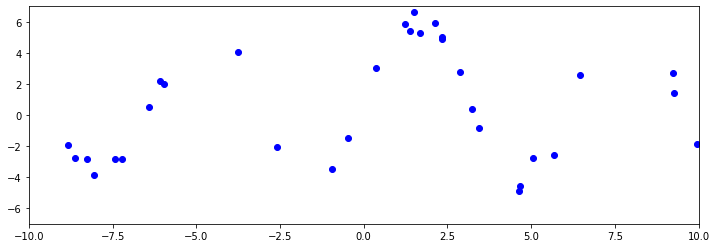

In [3]:
np.random.seed(seed = 2021)
x_fit = (np.random.rand(32) * 20 - 10).reshape((32, 1))
y_fit = np.sin(x_fit[:, 0]) * 5 + np.random.rand(32) * 2
x_pseudo = (np.random.rand(32) * 20 - 10).reshape((32, 1))

plt.figure(figsize = (12, 4))
plt.scatter(x_fit[:, 0], y_fit, c = "blue")
plt.xlim(-10, 10)
plt.ylim(-7, 7)
plt.show()

### 誘導点の数を変えたときの予測分布の近似分布

誘導点の数を変えて繰り返し学習と予測を行い、それぞれの予測結果を図示する。図の意味は以下の通り。

* 青色の点：学習データ
* 灰色の縦線：誘導点
* 青色の曲線：予測分布の平均
* 灰色の曲線：予測分布の平均±σ

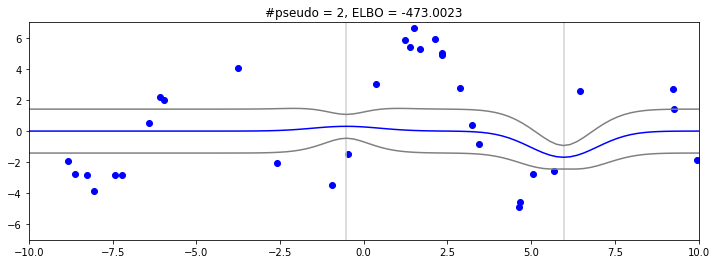

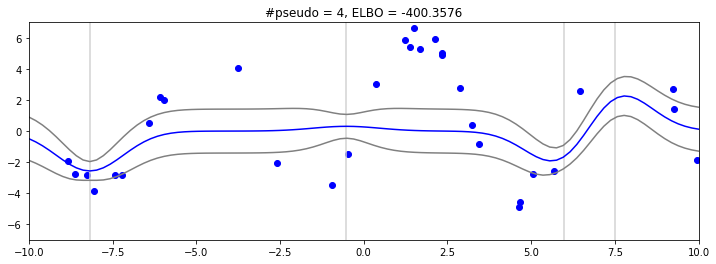

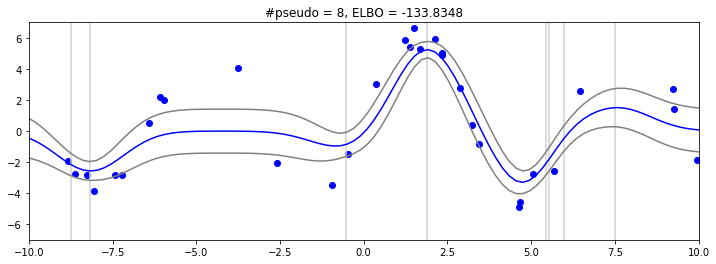

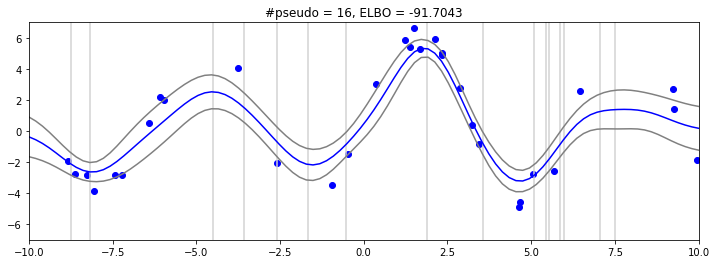

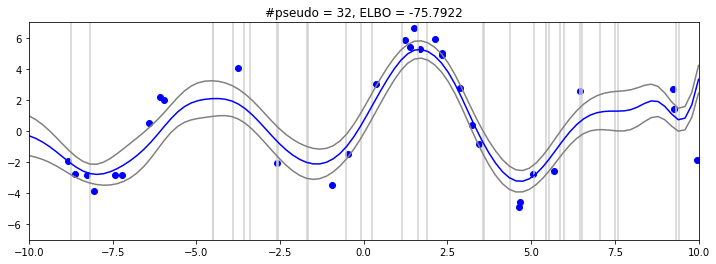

In [4]:
sigma = 2
l = 1
rbf = lambda x_left, x_right: sigma * np.exp(-1 * np.sum((x_left - x_right) ** 2) / (2 * l ** 2))

for i in [2, 4, 8, 16, 32]:
    gp = SparseGaussianProcessRegression(kernel = rbf, beta = 0.5, epochs = 5)
    gp = gp.fit(x_fit, y_fit, x_pseudo[0:i, :])

    x_predict = np.linspace(-10, 10, 100).reshape((100, 1))
    mu_f_predict, sigma_f_predict = gp.predict_dist(x_predict)

    plt.figure(figsize = (12, 4))
    plt.scatter(x_fit[:, 0], y_fit, c = "blue")
    plt.vlines(x_pseudo[0:i, 0], -7, 7, "lightgray")
    plt.plot(x_predict[:, 0], mu_f_predict, c = "blue")
    plt.plot(x_predict[:, 0], mu_f_predict + np.sqrt(np.diag(sigma_f_predict)), c = "gray")
    plt.plot(x_predict[:, 0], mu_f_predict - np.sqrt(np.diag(sigma_f_predict)), c = "gray")
    plt.title("#pseudo = {:d}, ELBO = {:.4f}".format(i, gp.elbo))
    plt.xlim(-10, 10)
    plt.ylim(-7, 7)
    plt.show()

### 誘導点を貪欲的に選んだときの予測分布の近似分布

その時点でELBOを最も改善する誘導点を1点追加して学習と予測を行う、という処理を繰り返し、各時点の予測結果を図示する。

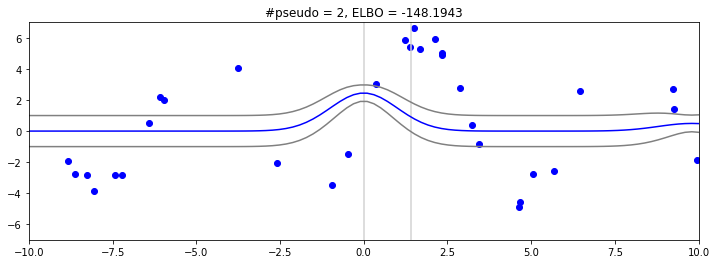

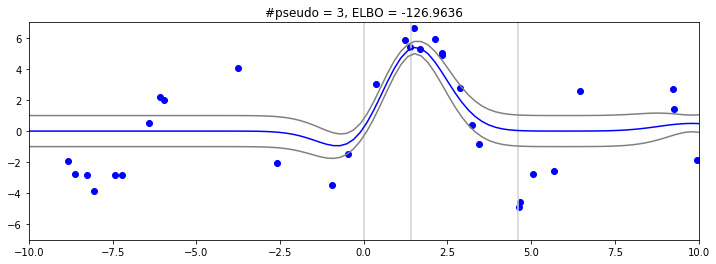

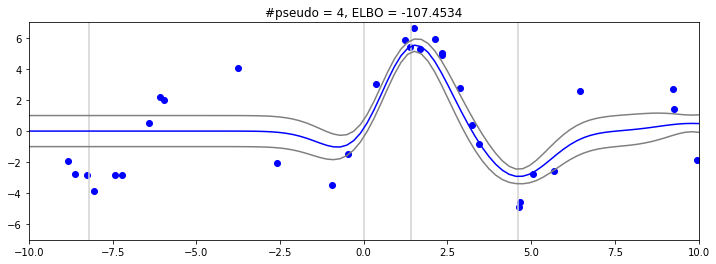

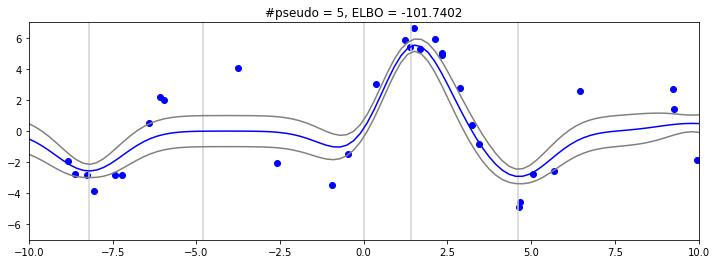

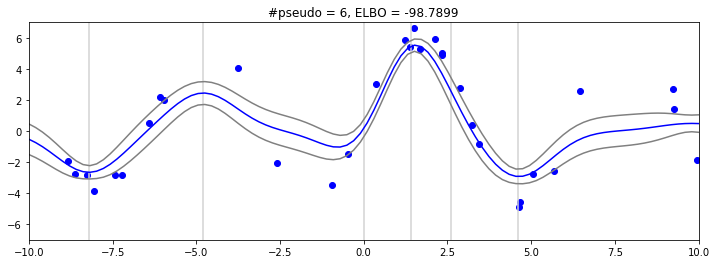

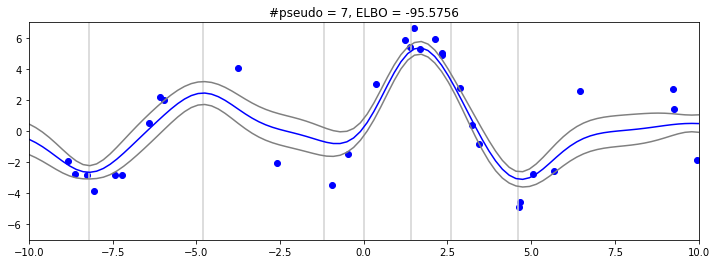

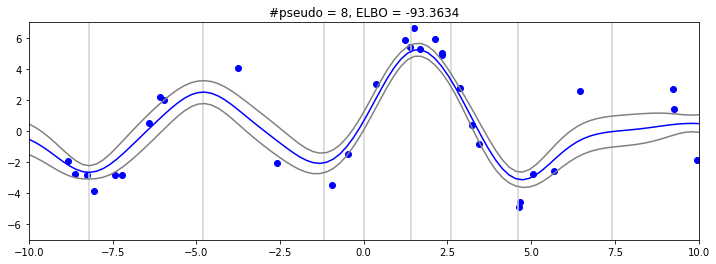

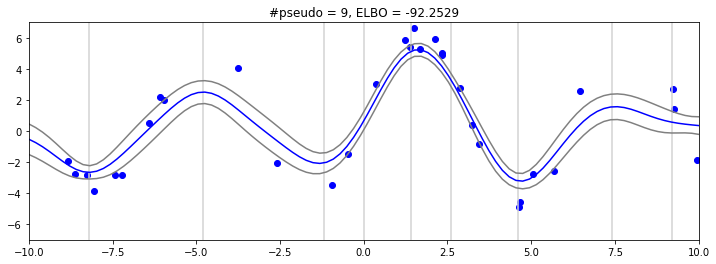

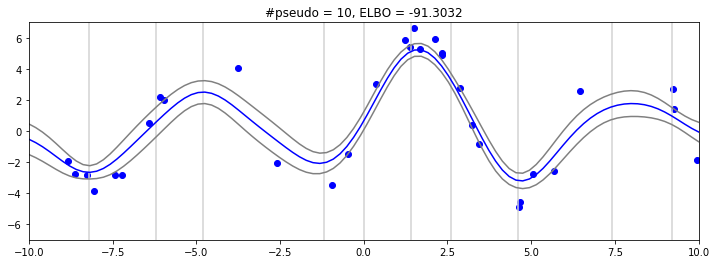

In [5]:
sigma = 1
l = 1
rbf = lambda x_left, x_right: sigma * np.exp(-1 * np.sum((x_left - x_right) ** 2) / (2 * l ** 2))

x_pseudo = np.array([0]).reshape((1, 1))
for i in range(2, 11):
    # ELBOを最も改善する誘導点を追加する。
    best_elbo = float("-inf")
    best_candidate = None
    for candidate in np.arange(-10, 10, 0.2):
        if candidate not in x_pseudo:
            gp = SparseGaussianProcessRegression(kernel = rbf, beta = 1, epochs = 5)
            gp = gp.fit(x_fit, y_fit, np.vstack((x_pseudo, candidate)))
            if best_elbo < gp.elbo:
                best_elbo = gp.elbo
                best_candidate = candidate
    x_pseudo = np.vstack((x_pseudo, best_candidate))

    x_predict = np.linspace(-10, 10, 100).reshape((100, 1))
    mu_f_predict, sigma_f_predict = gp.predict_dist(x_predict)

    plt.figure(figsize = (12, 4))
    plt.scatter(x_fit[:, 0], y_fit, c = "blue")
    plt.vlines(x_pseudo[:, 0], -7, 7, "lightgray")
    plt.plot(x_predict[:, 0], mu_f_predict, c = "blue")
    plt.plot(x_predict[:, 0], mu_f_predict + np.sqrt(np.diag(sigma_f_predict)), c = "gray")
    plt.plot(x_predict[:, 0], mu_f_predict - np.sqrt(np.diag(sigma_f_predict)), c = "gray")
    plt.title("#pseudo = {:d}, ELBO = {:.4f}".format(i, best_elbo))
    plt.xlim(-10, 10)
    plt.ylim(-7, 7)
    plt.show()